<a href="https://colab.research.google.com/github/ahmad1jalal/Transfer-Learning-with-TensorFlow/blob/main/Transfer_Learning_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries....

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
import pathlib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
# check for GPU
!nvidia-smi

Thu Aug  4 20:41:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    35W /  70W |   8958MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# downloading the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-08-04 20:41:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.188.48, 172.217.15.80, 172.217.0.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.188.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.3’

10_food_classes_10_ 100%[===================>] 160.74M   210MB/s    in 0.8s    

2022-08-04 20:41:02 (210 MB/s) - ‘10_food_classes_10_percent.zip.3’ saved [168546183/168546183]



In [ ]:
# unzip the data.....
zipfile = zipfile.ZipFile("10_food_classes_10_percent.zip","r")
zipfile.extractall()
zipfile.close()

In [ ]:
# walk through the directories....
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 10 director

## Preparing the Data:

In [ ]:
# setting up the directories...
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# setting up the batch and image shape
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

# setting up the train and test data gen
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print(f"Training Images :")
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=IMAGE_SHAPE,
                                               class_mode="categorical")

print(f"\nTesting Images....")
test_data = test_datagen.flow_from_directory(test_dir,batch_size=BATCH_SIZE,
                                             target_size=IMAGE_SHAPE,
                                             class_mode='categorical')

Training Images :
Found 750 images belonging to 10 classes.

Testing Images....
Found 2500 images belonging to 10 classes.


In [ ]:
  # setting up the tensorboard callback
  # it log the performance of different models and then view and compare these models in visual way....
  def create_tensorboard_callback(dirname,experiment_name):
    log_dir = dirname + "/"+ experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir = log_dir)
    print(f"Saving TensorBoard Files to : {log_dir}" )
    return tensorboard_callback

## Creating Model using TensorFlow Hub:

Previously, we were making models from scratch by defining each layer by layer. But now we'll import from TensorFlow_Hub.

In fact, we're going to use two models which are as follows:

**ResNetV2:** a state of art model from 2016

**EfficientNet:** a state of art model from 2019

State of art means at some point these models has achieved low error rate defined by ImageNet.

In [ ]:
# EfficientNet URL
efficientnet_url1 = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# Resnet Feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [ ]:
# we'll create a function that takes url, initialize the model and return the model
def create_model(model_url,num_classes=10):

  # download the model and save it as keraslayer
  feature_extractor_layer = hub.KerasLayer(model_url,trainable=False,
                                           name= "feature_extraction_layer",
                                           input_shape = (224,224,3))
  
  # create our own model
  model = Sequential()
  # adding layers...
  model.add(feature_extractor_layer)
  model.add(Dense(num_classes,activation="softmax",name="output_layer"))

  # return the model
  return model

In [ ]:
# create a model
resnet_model = create_model(resnet_url,train_data.num_classes)


In [ ]:
# compile the model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

# fit the model

resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch = len(train_data),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                              callbacks = [create_tensorboard_callback("tensorflow_hub",'resnet50v2')])

Saving TensorBoard Files to : tensorflow_hub/resnet50v2/20220804-204126
Epoch 1/5
24/24 [==============================] - 21s 755ms/step - loss: 1.9356 - accuracy: 0.3400 - val_loss: 1.2515 - val_accuracy: 0.6080
Epoch 2/5
24/24 [==============================] - 16s 706ms/step - loss: 0.8953 - accuracy: 0.7333 - val_loss: 0.8843 - val_accuracy: 0.7248
Epoch 3/5
24/24 [==============================] - 17s 723ms/step - loss: 0.6076 - accuracy: 0.8307 - val_loss: 0.7893 - val_accuracy: 0.7488
Epoch 4/5
24/24 [==============================] - 16s 686ms/step - loss: 0.4767 - accuracy: 0.8827 - val_loss: 0.7273 - val_accuracy: 0.7672
Epoch 5/5
24/24 [==============================] - 16s 687ms/step - loss: 0.3761 - accuracy: 0.9187 - val_loss: 0.6833 - val_accuracy: 0.7768


In [ ]:
# let's make a function that will visualize the performance of the model...

def plot_loss_curves(history):

  # getting the values of loss and accuracy
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  # getting the number of epochs
  epochs = range(len(loss))

  # plotting the loss
  plt.plot(epochs,loss,label="Training Loss")
  plt.plot(epochs,val_loss,label="Val_Loss")
  plt.legend()
  plt.title("Loss")
  plt.xlabel("Epochs")

  # plotting the accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="Training Accuracy")
  plt.plot(epochs,val_acc,label="Val_Accuracy")
  plt.legend()
  plt.title("Accuracy")
  plt.xlabel("Epochs");



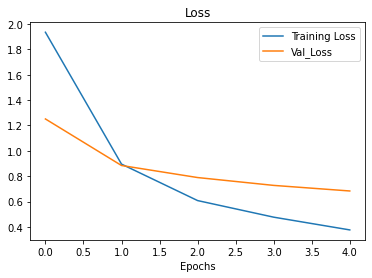

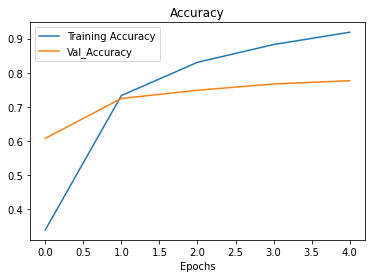

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
# let's check the model summary
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# we've trained resnet model and it's time to train the efficient model
# let's build it...

efficient_model = create_model(model_url=efficientnet_url1,num_classes=train_data.num_classes)

# compile the model
efficient_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

# fittin the model
efficient_history = efficient_model.fit(train_data,epochs=5,
                                        steps_per_epoch = len(train_data),
                                        validation_data = test_data,
                                        validation_steps = len(test_data),
                                        callbacks = [create_tensorboard_callback(dirname="tensorflow_hub",experiment_name="efficientnetB0")])

Saving TensorBoard Files to : tensorflow_hub/efficientnetB0/20220804-210056
Epoch 1/5
24/24 [==============================] - 27s 759ms/step - loss: 1.7696 - accuracy: 0.4893 - val_loss: 1.2587 - val_accuracy: 0.7464
Epoch 2/5
24/24 [==============================] - 15s 656ms/step - loss: 1.0376 - accuracy: 0.7827 - val_loss: 0.8492 - val_accuracy: 0.8188
Epoch 3/5
24/24 [==============================] - 16s 690ms/step - loss: 0.7454 - accuracy: 0.8253 - val_loss: 0.6898 - val_accuracy: 0.8416
Epoch 4/5
24/24 [==============================] - 15s 654ms/step - loss: 0.6043 - accuracy: 0.8640 - val_loss: 0.6061 - val_accuracy: 0.8544
Epoch 5/5
24/24 [==============================] - 16s 680ms/step - loss: 0.5094 - accuracy: 0.8867 - val_loss: 0.5543 - val_accuracy: 0.8640


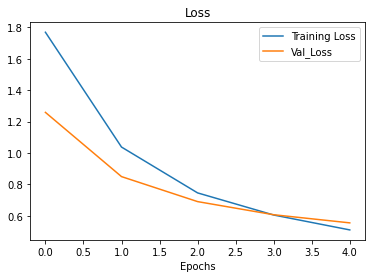

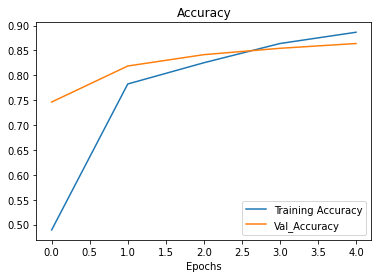

In [ ]:
# let's plot the model performance
plot_loss_curves(efficient_history)

In [ ]:
# for a look at loss and accuracy curves, if we train our model for a bit more long time then it might improve it's performance
# let's check the model summary
efficient_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


## Comparing Model using TensorBoard

Although we've compare the performance of two models by looking at the accuracy and loss of models. But let's compare these two more effieciently by using the TensorFlow TensorBoard feature.

TensorBoard keeps the track of model experiments and enable us to share it with the others by shaing the link.

In [ ]:
# upload experiment to the tensorboard
# Upload an experiment:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
    --name "EfficientnetB0 vs Resnet50V2" \
    --description "Comparing two model's performance using 10% data"\
    --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/ytYTDHvRS5CWYyJVMwAJew/

[2022-08-04T21:25:08] Started scanning logdir.
[2022-08-04T21:25:12] Total uploaded: 96 scalars, 0 tensors, 4 binary objects (9.2 MB)
[2022-08-04T21:25:12] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/ytYTDHvRS5CWYyJVMwAJew/


In [ ]:
# as all the upload to the tensorbord are public. let's delete the last 
!tensorboard dev delete --experiment_id ytYTDHvRS5CWYyJVMwAJew

Deleted experiment ytYTDHvRS5CWYyJVMwAJew.


In [ ]:
# checking the list of experiments
!tensorboard dev list

No experiments. Use `tensorboard dev upload` to get started.


## Fine Tunning

In fine tunning transfer learning the pre-trained model weights from another model are unfrozen and tweaked during training.

In feature extraction section we just trained the top 3 layers while in fine tunning, we might train more than 3 layers to get better results. Let's dive in!

We're going to cover the following things:


*   Model 0 : Transfer learning using keras Functional API

*   Model 1 : feature extraction using 1% of data with augmentation

*   Model 2 : feature extraction using 10% of data with augmentation

*   Model 3 : fine tuned transfer learning on 10% data

*   Model 4 : fine tuned transfer learning on 100% data


*   List item


*   List item


*   List item



In [ ]:
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [ ]:
# let's again walk through the directory
for dirpath,dirnames,filenames in os.walk("/content/10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in /content/10_food_classes_10_percent
There are 10 directories and 0 images in /content/10_food_classes_10_percent/train
There are 0 directories and 75 images in /content/10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in /content/10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in /content/10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in /content/10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in /content/10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in /content/10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in /content/10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in /content/10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in /content/10_food_classes_10_percent/train/hamburger
Th

## Model 0 :  Build a model using transfer learning Functional API

We're going to build our model by using tf.keras.applications module as it contains series of pre-trained models.

In [ ]:
# let's build the model using functional keras API

# create base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # set the include_top = False because we're going to create our own output layers

# freeze the pre-trained patterns...
base_model.trainable = False

# create inputs to the base model
inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# pass the inputs to the model
X = base_model(inputs)

# pool the output layers basically aggregate all the important imformation
X = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(X)

# create the output layer
outputs = tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(X)

# combine the inputs and outputs
model_0 = tf.keras.Model(inputs,outputs)

# compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# fitting the model
history_0 = model_0.fit(train_data,epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data = test_data,
                        validation_steps = int(0.25 * len(test_data)),
                        callbacks = [create_tensorboard_callback('transfer_learning','10_percent_data')])

Saving TensorBoard Files to : transfer_learning/10_percent_data/20220804-232212
Epoch 1/5
24/24 [==============================] - 14s 340ms/step - loss: 2.3243 - accuracy: 0.0760 - val_loss: 2.3055 - val_accuracy: 0.1036
Epoch 2/5
24/24 [==============================] - 9s 379ms/step - loss: 2.3197 - accuracy: 0.0960 - val_loss: 2.3042 - val_accuracy: 0.1003
Epoch 3/5
24/24 [==============================] - 9s 374ms/step - loss: 2.3113 - accuracy: 0.1120 - val_loss: 2.3047 - val_accuracy: 0.0938
Epoch 4/5
24/24 [==============================] - 9s 376ms/step - loss: 2.3107 - accuracy: 0.1013 - val_loss: 2.3042 - val_accuracy: 0.1053
Epoch 5/5
24/24 [==============================] - 9s 373ms/step - loss: 2.3112 - accuracy: 0.0987 - val_loss: 2.3021 - val_accuracy: 0.0872


so far our model has achieved 98% accuracy on training and 87% accuracy on test data. This is the power of transfer learning.

In [ ]:
# let's check out the layers...
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number , layer)

0 <keras.engine.input_layer.InputLayer object at 0x7fd6b2cd5290>
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fd6b4b18190>
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7fd6b2dd23d0>
3 <keras.layers.convolutional.ZeroPadding2D object at 0x7fd6b60d6250>
4 <keras.layers.convolutional.Conv2D object at 0x7fd6b4f6b610>
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd6b4a8a910>
6 <keras.layers.core.activation.Activation object at 0x7fd6b603e550>
7 <keras.layers.convolutional.DepthwiseConv2D object at 0x7fd6b2cf2cd0>
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd6b4aa6c50>
9 <keras.layers.core.activation.Activation object at 0x7fd6b2cefe10>
10 <keras.layers.pooling.GlobalAveragePooling2D object at 0x7fd6b2c7a4d0>
11 <keras.layers.core.reshape.Reshape object at 0x7fd6b4aa0b10>
12 <keras.layers.convolutional.Conv2D object at 0x7fd6b2c84990>
13 <keras.layers.convolutional

In [ ]:
# checkout the model summary
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_2 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

In [ ]:
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


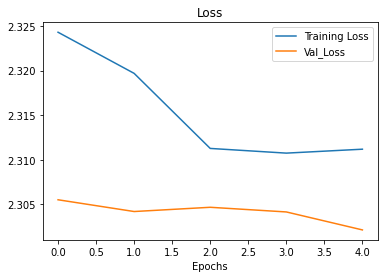

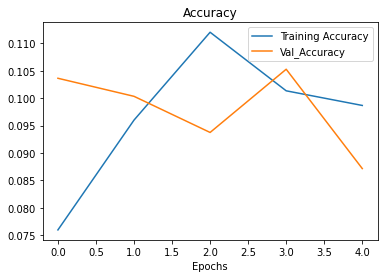

In [ ]:
# visualize the model performance
plot_loss_curves(history_0)

In [ ]:
# download the 1% zip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2022-08-04 23:27:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   118MB/s    in 1.1s    

2022-08-04 23:27:27 (118 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# let's unzip the data....
zipfile = zipfile.ZipFile("/content/10_food_classes_1_percent.zip")
zipfile.extractall()
zipfile.close()

In [ ]:
# creating directories of 1% data
# /content/10_food_classes_1_percent/train
train_dir_1_percent = "/content/10_food_classes_1_percent/train"
test_dir_1_percent = "/content/10_food_classes_1_percent/test/"

In [ ]:
# but first let's walk through the directory
for dirpath,dirnames,filenames in os.walk("10_food_classes_1_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

There are 2 directories and 0 images in 10_food_classes_1_percent.
There are 10 directories and 0 images in 10_food_classes_1_percent/train.
There are 0 directories and 7 images in 10_food_classes_1_percent/train/steak.
There are 0 directories and 7 images in 10_food_classes_1_percent/train/chicken_wings.
There are 0 directories and 7 images in 10_food_classes_1_percent/train/grilled_salmon.
There are 0 directories and 7 images in 10_food_classes_1_percent/train/chicken_curry.
There are 0 directories and 7 images in 10_food_classes_1_percent/train/pizza.
There are 0 directories and 7 images in 10_food_classes_1_percent/train/fried_rice.
There are 0 directories and 7 images in 10_food_classes_1_percent/train/ice_cream.
There are 0 directories and 7 images in 10_food_classes_1_percent/train/sushi.
There are 0 directories and 7 images in 10_food_classes_1_percent/train/hamburger.
There are 0 directories and 7 images in 10_food_classes_1_percent/train/ramen.
There are 10 directories and 0 

In [ ]:
# let's load our images...
IMAGE_SIZE = (224,224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           batch_size=32,image_size=IMAGE_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                label_mode='categorical',
                                                                image_size=IMAGE_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# previously we do data-augmentation in the ImageDataGenerator to augment our training images,this time we're going to build data
# augmentation right into the model

# create data-augmentation stage with horizontal flipping, rotation, zooms
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),],name="data_augmentation")

## Model 1 : Feautr Extraction model on 1% data with data augmentation

In [ ]:
# let's build the model
# set the random seed
tf.random.set_seed(42)

# set-up the base-model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# frooze the pre-trained learned patterns
base_model.trainable=False

# setting up the inputs 
inputs = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

# setting up the data-augmentation
x = data_augmentation(inputs)

# give the base model inputs after data-augmentation
x = base_model(x,training=False)

# pool the features
x = tf.keras.layers.GlobalAveragePooling2D(name='pooling_layer')(x)

# output layer
outputs = tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(x)

# combining the layers and making up the model
model_1 = tf.keras.Model(inputs,outputs)

# compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# fitting the model
history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch= len(train_data_1_percent),
                        validation_data = test_data,
                        validation_steps = int(0.25 * len(test_data)),
                        callbacks = [create_tensorboard_callback('transfer_learning',"1_percent_data_aug")])

Saving TensorBoard Files to : transfer_learning/1_percent_data_aug/20220805-003841
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.4304 - accuracy: 0.0857 - val_loss: 2.3576 - val_accuracy: 0.1036
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.2008 - accuracy: 0.1857 - val_loss: 2.2457 - val_accuracy: 0.1661
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9939 - accuracy: 0.3000 - val_loss: 2.1251 - val_accuracy: 0.2368
Epoch 4/5
3/3 [==============================] - 6s 3s/step - loss: 1.7991 - accuracy: 0.4714 - val_loss: 2.0509 - val_accuracy: 0.2812
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6678 - accuracy: 0.6286 - val_loss: 1.9647 - val_accuracy: 0.3289


In [ ]:
# let's check-out the model summary
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

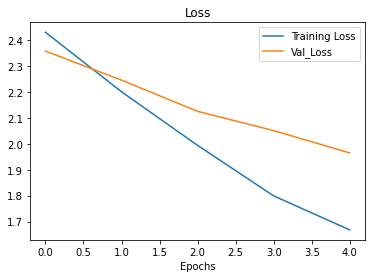

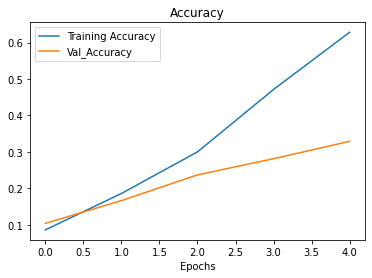

In [ ]:
# visualize the model performance
plot_loss_curves(history_1)

## Model 2 : Feature extraction transfer learning on 10% with data-augmentation

In [ ]:
# make dir for 10% data
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
# create the data-loaders for augmentation
IMAGE_SHAPE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            image_size=IMAGE_SHAPE,
                                                                            label_mode='categorical',
                                                                            )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMAGE_SHAPE,
                                                                label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# create data-augmentation layer for 10% data
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2)
],name='data-augmentation')

In [ ]:
# let's build the model

# set the random-seed
tf.random.set_seed(42)

# set the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False) #because we'll make our own output layers
# set the trainable false
base_model.trainable = False

# input layer
inputs = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

x = data_augmentation(inputs)
x = base_model(x,training=False)
x = tf.keras.layers.MaxPooling2D(name='global_average_pooling_layer')(x)

# output layer
output = tf.keras.layers.Dense(10,activation='softmax',name='output')(x)

# making model
model_2 = tf.keras.Model(inputs,output)

# compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# fitting the model
history_2 = model_2.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch= len(train_data_10_percent),
                        validation_data = test_data,
                        validation_steps = int(0.25 * len(test_data)),)
                        #callbacks = [create_tensorboard_callback('transfer_learning',"10_percent_data_aug")])

Epoch 1/5


ValueError: ignored